# Estimación del Modelo

In [1]:
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import het_white, het_breuschpagan, acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import jarque_bera, normaltest
import scipy.stats as stats
import pandas as pd

In [2]:
car_data = pd.read_excel("car_dataframe_clean.xlsx")
car_data.head()

,fuel_consumption_km_l,traccion,transmision,horsepower,fuel_type,displacement,gears,engine_type,torque,turbo,brand,age
0,7,4x2,Automatico,449,Estandar,3.0,7,Combustion,516,Sí,Mercedes Benz,9
1,10,4x4,Automatico,310,Estandar,3.0,8,Combustion,325,Sí,Audi,7
2,11,4x4,Automatico,300,Estandar,2.0,8,Combustion,295,Sí,Jaguar Xe,6
3,17,4x2,Automatico,150,Estandar,1.4,7,Combustion,148,Sí,Seat,6
4,12,4x4,Automatico,320,Gasolina,2.0,8,Combustion,295,Sí,Volvo,7


In [3]:
car_data.describe()

,fuel_consumption_km_l,horsepower,displacement,gears,torque,age
count,1196.000000,1196.000000,1196.000000,1196.000000,1196.000000,1196.000000
mean,12.586120,183.068562,2.160953,6.217391,188.661371,7.584448
std,3.447166,80.714458,0.927473,1.188325,81.780796,2.315758
min,5.000000,66.000000,1.000000,4.000000,67.000000,3.000000
25%,9.000000,121.000000,1.600000,6.000000,117.000000,6.000000
50%,13.000000,156.000000,2.000000,6.000000,177.000000,7.000000
75%,15.000000,240.000000,2.500000,7.000000,253.000000,9.000000
max,30.000000,557.000000,6.200000,10.000000,561.000000,15.000000


In [4]:
# Preparar los datos para la regresión
# 'fuel_consumption_km_l' es la variable dependiente (y)
# resto de las columnas numéricas son las independientes (X)


car_data_cleaned = car_data.copy()
car_data_cleaned = car_data_cleaned.dropna()


X = car_data_cleaned[['horsepower', 'displacement', 'gears', 'torque', 'age']]
y = car_data_cleaned['fuel_consumption_km_l']

In [5]:
# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
X_with_const = sm.add_constant(X_scaled)

model = sm.OLS(y, X_with_const).fit()

In [7]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     fuel_consumption_km_l   R-squared:                       0.579
Model:                               OLS   Adj. R-squared:                  0.577
Method:                    Least Squares   F-statistic:                     327.2
Date:                   Mon, 23 Sep 2024   Prob (F-statistic):          1.52e-220
Time:                           01:46:29   Log-Likelihood:                -2659.4
No. Observations:                   1196   AIC:                             5331.
Df Residuals:                       1190   BIC:                             5361.
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5861      0.065    194.179      0.000      12.459      12.713
x1            -1.2392      0.265     -4.681      0.000      -1.759      -0.720
x2            -1.1816      0.133     -8.867      0.000      -1.443      -0.920
x3            -0.1173      0.086     -1.362      0.174      -0.286       0.052
x4            -0.1836      0.223     -0.823      0.411      -0.621       0.254
x5            -0.2673      0.069     -3.899      0.000      -0.402      -0.133
==============================================================================
Omnibus:                      362.314   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3594.534
Skew:                           1.104   Prob(JB):                         0.00
Kurtosis:                      11.201   Cond. No.                         9.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
import numpy as np

residuals = model.resid

mse = np.mean(residuals**2)
rmse = np.sqrt(mse)
print(f"MSE: {mse: .3f}")
print(f"RMSE: {rmse: .3f}")

MSE:  5.000
RMSE:  2.236


# Validación de Supuestos

## Multicolinealidad

In [9]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
vif_data

,Feature,VIF
0,horsepower,16.682906
1,displacement,4.226330
2,gears,1.767356
3,torque,11.839518
4,age,1.118983


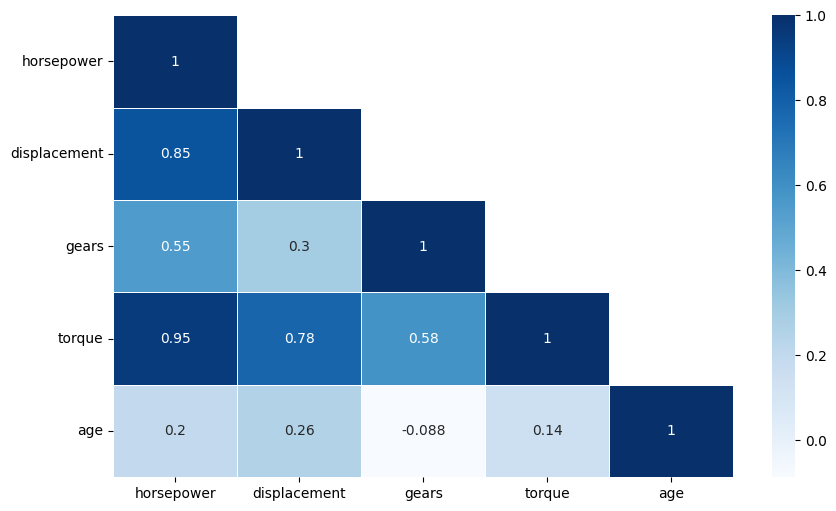

In [10]:
correlation_matrix = X.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', linewidths=0.5, mask=mask)
plt.yticks(rotation=0)
plt.title("")
plt.show()

## Heterocedasticidad



In [11]:
residuals = model.resid

# Realizar la prueba de White para heterocedasticidad
white_test = het_white(residuals, model.model.exog)
white_test

(35.77398999138439,
 0.016348901512457947,
 1.8114762932941177,
 0.015571996442385118)

In [12]:
# Heterocedasticidad - Prueba de Breusch Pagan
bp_test = het_breuschpagan(model.resid, X_with_const)
bp_test

(7.112715845460821,
 0.21239155874764504,
 1.4238745706019553,
 0.2127962716747104)

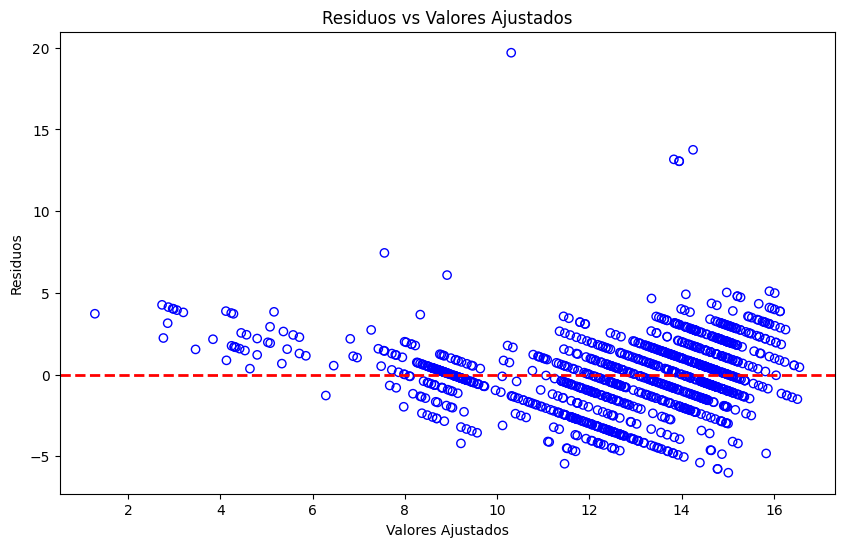

In [13]:
# Gráfico de dispersión para verificar la heterocedasticidad
plt.figure(figsize=(10,6))
plt.scatter(model.fittedvalues, model.resid, edgecolors='b', facecolors='none')
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.title('Residuos vs Valores Ajustados')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.show()

##  Autocorrelación

In [14]:
# Prueba Durbin Watson
durbin_watson_test = durbin_watson(model.resid)
durbin_watson_test

1.9190208764412073

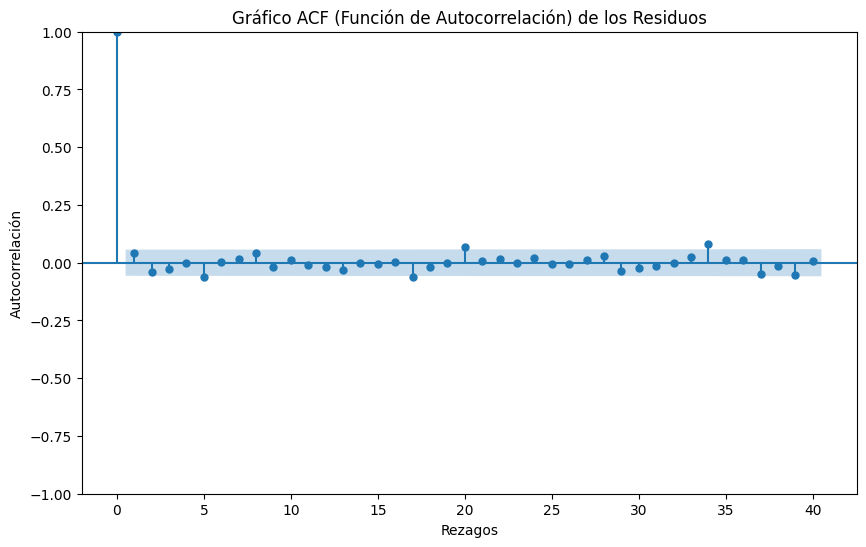

In [15]:
#correlograma

import statsmodels.api as sm
import matplotlib.pyplot as plt

# Gráfico ACF (Autocorrelation Function) para los residuos del modelo
fig, ax = plt.subplots(figsize=(10,6))
sm.graphics.tsa.plot_acf(model.resid, lags=40, ax=ax)
plt.title('Gráfico ACF (Función de Autocorrelación) de los Residuos')
plt.xlabel('Rezagos')
plt.ylabel('Autocorrelación')
plt.show()
#: Esta función genera el gráfico ACF, que muestra la autocorrelación de los residuos en diferentes rezagos (lags).
# Esto especifica que el gráfico mostrará hasta 40 rezagos.

#Si las barras están dentro del intervalo de confianza (generalmente las líneas punteadas), no hay evidencia de autocorrelación significativa.
#algunas barras están fuera del intervalo, podría haber autocorrelación en esos rezagos.


##  No normalidad de los errores

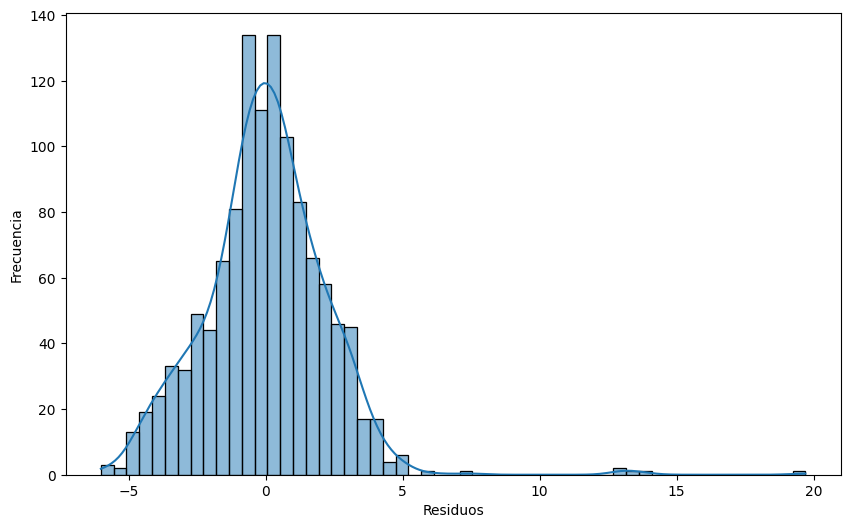

In [16]:
# No normalidad de los errores - Histograma de los residuos
plt.figure(figsize=(10,6))
sns.histplot(model.resid, kde=True)
#plt.title('Histograma de los residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.show()

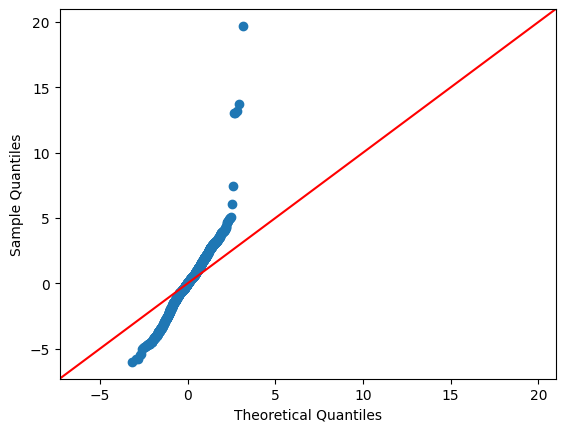

In [17]:
# No normalidad de los errores - Gráfico Q-Q
sm.qqplot(model.resid, line ='45')
#plt.title('Gráfico Q-Q de los residuos')
plt.show()

In [18]:
# Pruebas de normalidad - Prueba de Jarque-Bera
jarque_bera_test = jarque_bera(model.resid)
jarque_bera_test

SignificanceResult(statistic=3594.533790805854, pvalue=0.0)

In [19]:
# Pruebas de normalidad - Prueba de Shapiro-Wilk
shapiro_wilk_test = normaltest(model.resid)
shapiro_wilk_test

NormaltestResult(statistic=362.31390260875816, pvalue=2.1112306885070678e-79)